In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [2]:
df=pd.read_csv("Dataset_1.csv")
df.head(5)

,Command,Camera
0,Follow the person in front of you.,1
1,Detect any obstacles and avoid them.,1
2,Scan the area for moving objects.,1
3,Identify the red car below and hover above it.,1
4,Track the object moving to the right.,1


In [3]:
df.groupby('Camera').describe()

Command                                                          
         count unique                                           top freq
Camera                                                                  
0           60     60  Fly to the coordinates (37.7749, -122.4194).    1
1           60     60            Follow the person in front of you.    1

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Command'],df['Camera'], stratify=df['Camera'], test_size=0.1)

In [22]:
print(len(X_test))
X_train.head(4)


12


21                           Return to the launch point.
111                     Descend and prepare for landing.
70      Return to home position and prepare for landing.
48     Find the tallest building in the area and hove...
Name: Command, dtype: object

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [36]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [38]:
# BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="the_college_dropout")(outputs['pooled_output'])

# Adding multiple hidden layers
l = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_1")(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Dense(64, activation='relu', name="hidden_layer_2")(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Dense(32, activation='relu', name="hidden_layer_3")(l)

# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs=[output])

# Print model summary to verify the structure
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [23]:
len(X_train)

108

In [40]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [41]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
4/4 [==============================] - 22s 4s/step - loss: 0.8025 - accuracy: 0.4722 - precision: 0.4444 - recall: 0.2222
Epoch 2/10
4/4 [==============================] - 16s 4s/step - loss: 0.7330 - accuracy: 0.4907 - precision: 0.4941 - recall: 0.7778
Epoch 3/10
4/4 [==============================] - 17s 4s/step - loss: 0.7353 - accuracy: 0.5093 - precision: 0.5050 - recall: 0.9444
Epoch 4/10
4/4 [==============================] - 19s 5s/step - loss: 0.7094 - accuracy: 0.4352 - precision: 0.4462 - recall: 0.5370
Epoch 5/10
4/4 [==============================] - 17s 4s/step - loss: 0.6995 - accuracy: 0.4630 - precision: 0.4444 - recall: 0.2963
Epoch 6/10
4/4 [==============================] - 16s 4s/step - loss: 0.6911 - accuracy: 0.5926 - precision: 0.6786 - recall: 0.3519
Epoch 7/10
4/4 [==============================] - 19s 4s/step - loss: 0.6923 - accuracy: 0.5648 - precision: 0.5778 - recall: 0.4815
Epoch 8/10
4/4 [==============================] - 18s 4s/step - loss:

In [42]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 4s 4s/step - loss: 0.6817 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.6816737055778503, 0.5, 0.0, 0.0]

In [46]:
test = "move the drone 10 m"
prediction = model.predict([test])
prediction

1/1 [==============================] - 0s 407ms/step


array([[0.49340364]], dtype=float32)

In [27]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

1/1 [==============================] - 3s 3s/step


In [28]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1])

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[4, 2],
       [0, 6]])

Text(50.722222222222214, 0.5, 'Truth')

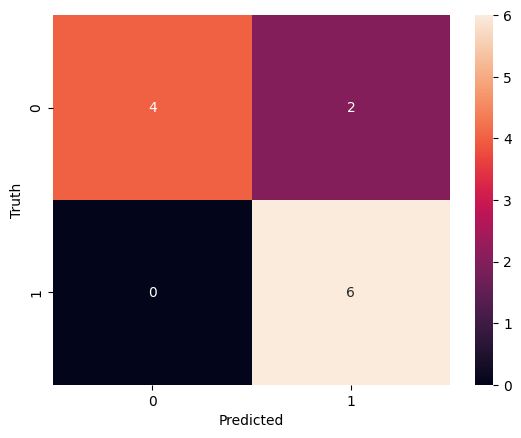

In [30]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [17]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      0.13      0.24        15
           1       0.54      1.00      0.70        15

    accuracy                           0.57        30
   macro avg       0.77      0.57      0.47        30
weighted avg       0.77      0.57      0.47        30

